# Santander Customer Transaction Prediction


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn models & tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


In [3]:
train = pd.read_csv("/kaggle/input/customer-transaction-prediction/train.csv")
test = pd.read_csv("/kaggle/input/customer-transaction-prediction/test.csv")

In [69]:
train.head()

target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8  ...  var_139_rounded  var_139_rounded_10  var_139_rounded_100  \
0 -4.9200  ...             16.0               157.0               1566.0   
1  3.1468  ...             16.0               162.0               1616.0   
2 -4.9193  ...              9.0                87.0                867.0   
3 -5.8609  ...              9.0                90.0                898.0   
4  6.2654  ...             14.0               140.0               1395.0   

      mean_r      min_r   max_r       std_r    skew_r    kurto_r  median_r  
0  80.671309  -515.0000  2436.0  304.697893  4.640137  23.766127   8.00000  
1  87.742877 -1177.0000  3026.0  332.182071  4.677489  29.719333   8.03470  
2  85.034291  -799.0000  2568.0  322.210507  4.813340  26.471806   7.00000  
3  80.833905   -35.1659  1797.0  267.486676  4.347133  19.413691   8.00000  
4  91.604647  -149.0000  2827.0  335.422296  5.039912  27.946788   7.89395  

[5 rows x 309 columns]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [6]:
train.dtypes.value_counts()

float64    200
object       1
int64        1
dtype: int64

In [7]:
test.dtypes.value_counts()

float64    200
object       1
dtype: int64

In [8]:
train.select_dtypes(include=['object'])

ID_code
0            train_0
1            train_1
2            train_2
3            train_3
4            train_4
...              ...
199995  train_199995
199996  train_199996
199997  train_199997
199998  train_199998
199999  train_199999

[200000 rows x 1 columns]

In [9]:
train.nunique(axis=0).sort_values()

target          2
var_68        451
var_91       7962
var_108      8525
var_103      9376
            ...  
var_61     159369
var_74     161058
var_117    164469
var_45     169968
ID_code    200000
Length: 202, dtype: int64

In [10]:
test.nunique(axis=0).sort_values()

var_68        428
var_91       7569
var_108      8188
var_103      8828
var_12       9121
            ...  
var_61      88874
var_74      89343
var_117     90342
var_45      92058
ID_code    200000
Length: 201, dtype: int64

# Missing values

In [11]:
train.isna().sum().sum()

0

In [12]:
test.isna().sum().sum()

0


# EDA



## Descriptive analysis

In [13]:
train_summary = train.describe()
train_summary

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [14]:
train_summary_1 = train[train['target'] == 1].describe()
train_summary_1

target         var_0         var_1         var_2         var_3  \
count  20098.0  20098.000000  20098.000000  20098.000000  20098.000000   
mean       1.0     11.156418     -1.017613     11.156633      6.864113   
std        0.0      3.270293      4.220638      2.841075      2.070898   
min        1.0      0.452800    -14.037000      2.946200      0.374000   
25%        1.0      8.695875     -4.203475      8.961125      5.314300   
50%        1.0     11.001350     -0.992650     11.096700      6.900200   
75%        1.0     13.343700      2.001375     13.047025      8.384725   
max        1.0     19.458300      9.029800     18.294100     12.706900   

              var_4         var_5         var_6         var_7         var_8  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      11.131337     -4.336522      5.581966     16.514917      0.479432   
std        1.649266      8.140281      0.922442      3.421365      3.340028   
min        5.876200    -28.246100      2.496000      7.302400     -9.839100   
25%        9.911250    -10.615800      4.882250     13.880125     -2.107425   
50%       11.156300     -4.101950      5.601800     16.412700      0.579600   
75%       12.328450      1.619950      6.218550     19.044250      3.127825   
max       15.692500     16.423600      8.285200     27.039800      9.033000   

       ...       var_190       var_191       var_192       var_193  \
count  ...  20098.000000  20098.000000  20098.000000  20098.000000   
mean   ...      3.998064      7.864560      1.738266      3.120260   
std    ...      4.814830      3.210779      1.482537      4.067550   
min    ...    -11.906900     -2.343000     -3.317700    -11.783400   
25%    ...      0.466025      5.418550      0.669775      0.343000   
50%    ...      4.017500      7.846550      1.667500      3.176700   
75%    ...      7.407925     10.018400      2.749050      6.063825   
max    ...     16.746100     16.520500      7.647600     17.150400   

            var_194       var_195       var_196       var_197       var_198  \
count  20098.000000  20098.000000  20098.000000  20098.000000  20098.000000   
mean      17.779568     -0.021130      2.688583      8.810815     15.393283   
std        3.193153      1.485975      5.556892      0.952554      3.248123   
min       10.120700     -5.018500    -14.020400      6.119000      6.558700   
25%       15.420025     -1.103950     -1.572225      8.155250     13.232500   
50%       17.730500     -0.057350      2.831050      8.795400     15.427950   
75%       20.201800      0.986450      6.956250      9.517000     17.776425   
max       27.295300      4.088100     17.161400     11.706900     25.857100   

            var_199  
count  20098.000000  
mean      -2.532243  
std       10.435910  
min      -38.852800  
25%      -10.285050  
50%       -1.971850  
75%        5.701475  
max       24.564600  

[8 rows x 201 columns]

In [15]:
train_summary_0 = train[train['target'] == 0].describe()
train_summary_0

target          var_0          var_1          var_2          var_3  \
count  179902.0  179902.000000  179902.000000  179902.000000  179902.000000   
mean        0.0      10.626681      -1.695770      10.665876       6.788979   
std         0.0       3.008564       4.024813       2.612961       2.040082   
min         0.0       0.408400     -15.043400       2.117100      -0.040200   
25%         0.0       8.429500      -4.790775       8.698025       5.247625   
50%         0.0      10.478600      -1.682600      10.529000       6.817000   
75%         0.0      12.693075       1.287700      12.463900       8.317875   
max         0.0      20.315000      10.376800      19.353000      13.188300   

               var_4          var_5          var_6          var_7  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean       11.072412      -5.146736       5.389620      16.549306   
std         1.620103       7.827522       0.857983       3.417700   
min         5.074800     -32.562600       2.347300       5.349700   
25%         9.880600     -11.260950       4.756425      13.950125   
50%        11.104400      -4.917700       5.364400      16.460850   
75%        12.253100       0.844600       5.981300      19.108800   
max        16.671400      17.251600       8.447700      27.691800   

               var_8  ...        var_190        var_191        var_192  \
count  179902.000000  ...  179902.000000  179902.000000  179902.000000   
mean        0.262347  ...       3.149130       7.390800       1.949017   
std         3.331105  ...       4.522568       2.997847       1.476456   
min       -10.505500  ...     -14.093300      -2.691700      -3.814500   
25%        -2.342575  ...      -0.111850       5.130825       0.915300   
50%         0.371400  ...       3.117250       7.297000       1.928950   
75%         2.919300  ...       6.296375       9.461300       2.969800   
max        10.151300  ...      18.440900      16.716500       8.402400   

             var_193        var_194        var_195        var_196  \
count  179902.000000  179902.000000  179902.000000  179902.000000   
mean        3.355403      18.017716      -0.155601       2.260297   
std         3.982819       3.127715       1.422275       5.441118   
min       -10.845500       8.694400      -5.261000     -14.209600   
25%         0.612400      15.656700      -1.178700      -1.987375   
50%         3.417550      17.982400      -0.184200       2.359700   
75%         6.217075      20.417500       0.813000       6.513425   
max        18.281800      27.928800       4.272900      18.321500   

             var_197        var_198        var_199  
count  179902.000000  179902.000000  179902.000000  
mean        8.919032      15.924058      -3.415273  
std         0.917467       2.978539      10.434525  
min         5.960600       6.299300     -38.852800  
25%         8.262100      13.896000     -11.312025  
50%         8.897700      15.988500      -2.914000  
75%         9.601500      18.095400       4.741400  
max        12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [16]:
test_summary = test.describe()
test_summary

var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658737      -1.624244      10.707452       6.788214   
std         3.036716       4.040509       2.633888       2.052724   
min         0.188700     -15.043400       2.355200      -0.022400   
25%         8.442975      -4.700125       8.735600       5.230500   
50%        10.513800      -1.590500      10.560700       6.822350   
75%        12.739600       1.343400      12.495025       8.327600   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076399      -5.050558       5.415164      16.529143   
std         1.616456       7.869293       0.864686       3.424482   
min         5.484400     -27.767000       2.216400       5.713700   
25%         9.891075     -11.201400       4.772600      13.933900   
50%        11.099750      -4.834100       5.391600      16.422700   
75%        12.253400       0.942575       6.005800      19.094550   
max        16.037100      17.253700       8.302500      28.292800   

               var_8          var_9  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean        0.277135       7.569407  ...       3.189766       7.458269   
std         3.333375       1.231865  ...       4.551239       3.025189   
min        -9.956000       4.243300  ...     -14.093300      -2.407000   
25%        -2.303900       6.623800  ...      -0.095000       5.166500   
50%         0.372000       7.632000  ...       3.162400       7.379000   
75%         2.930025       8.584825  ...       6.336475       9.531100   
max         9.665500      11.003600  ...      20.359000      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.925944       3.322016      17.996967      -0.133657   
std         1.479966       3.995599       3.140652       1.429678   
min        -3.340900     -11.413100       9.382800      -4.911900   
25%         0.882975       0.587600      15.634775      -1.160700   
50%         1.892600       3.428500      17.977600      -0.162000   
75%         2.956000       6.174200      20.391725       0.837900   
max         8.005000      17.632600      27.947800       4.545400   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.290899       8.912428      15.869184      -3.246342  
std         5.446346       0.920904       3.008717      10.398589  
min       -13.944200       6.169600       6.584000     -39.457800  
25%        -1.948600       8.260075      13.847275     -11.124000  
50%         2.403600       8.892800      15.943400      -2.725950  
75%         6.519800       9.595900      18.045200       4.935400  
max        15.920700      12.275800      26.538400      27.907400  

[8 rows x 200 columns]

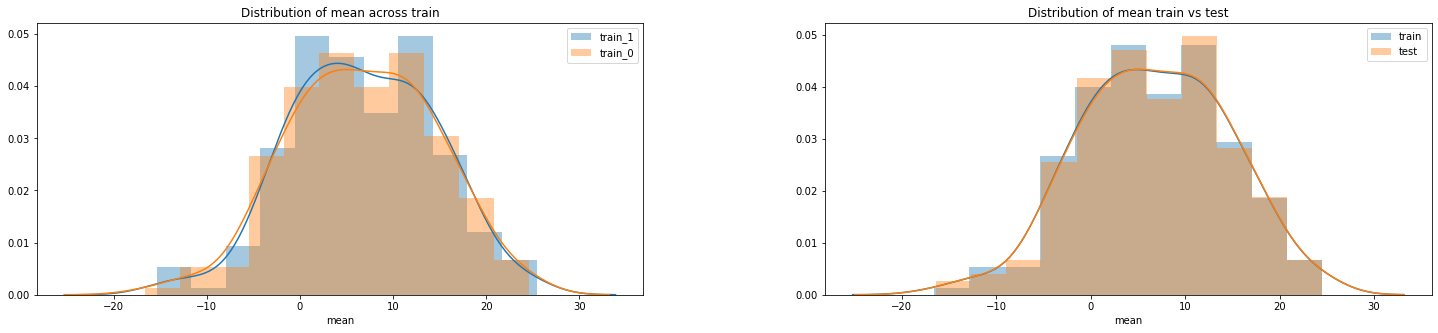

In [17]:
fig = plt.figure(figsize=(25,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3, )
ax = fig.add_subplot(1, 2, 1)
sns.distplot(train_summary_1.iloc[1], label="train_1" )
sns.distplot(train_summary_0.iloc[1], label="train_0" )
plt.title("Distribution of mean across train")
plt.legend()
ax = fig.add_subplot(1, 2, 2)
sns.distplot(train_summary.iloc[1], label="train")
sns.distplot(test_summary.iloc[1], label="test" )
plt.title("Distribution of mean train vs test")
plt.legend();

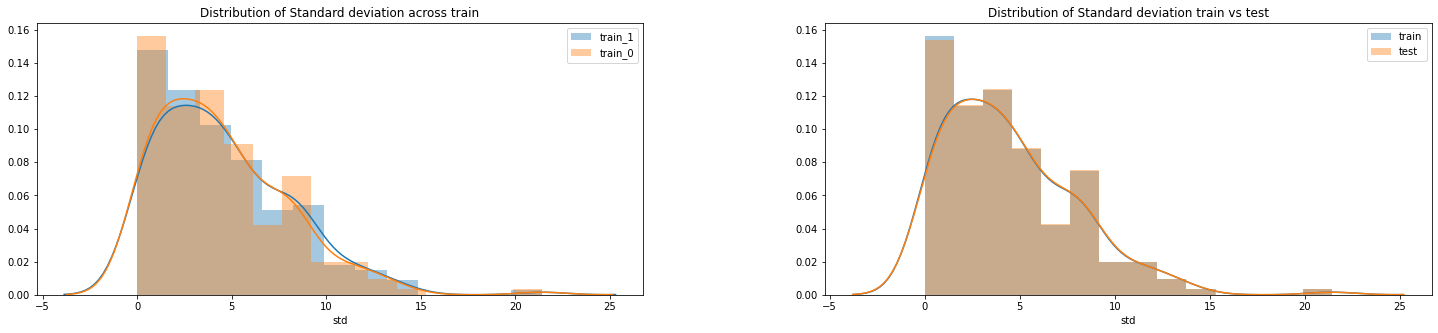

In [18]:
fig = plt.figure(figsize=(25,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3, )
ax = fig.add_subplot(1, 2, 1)
sns.distplot(train_summary_1.iloc[2], label="train_1" )
sns.distplot(train_summary_0.iloc[2], label="train_0" )
plt.title("Distribution of Standard deviation across train")
plt.legend()
ax = fig.add_subplot(1, 2, 2)
sns.distplot(train_summary.iloc[2], label="train")
sns.distplot(test_summary.iloc[2], label="test" )
plt.title("Distribution of Standard deviation train vs test")
plt.legend();

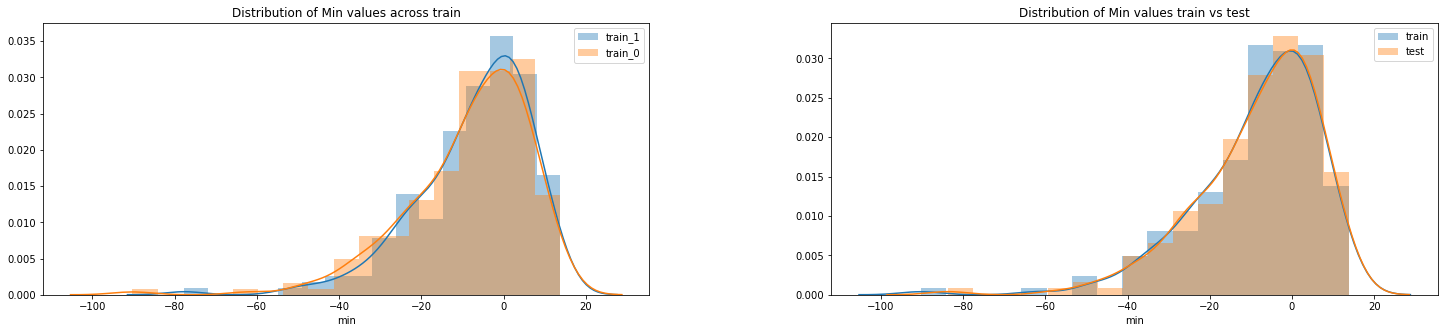

In [19]:
fig = plt.figure(figsize=(25,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3, )
ax = fig.add_subplot(1, 2, 1)
sns.distplot(train_summary_1.iloc[3], label="train_1" )
sns.distplot(train_summary_0.iloc[3], label="train_0" )
plt.title("Distribution of Min values across train")
plt.legend()
ax = fig.add_subplot(1, 2, 2)
sns.distplot(train_summary.iloc[3], label="train")
sns.distplot(test_summary.iloc[3], label="test" )
plt.title("Distribution of Min values train vs test")
plt.legend();

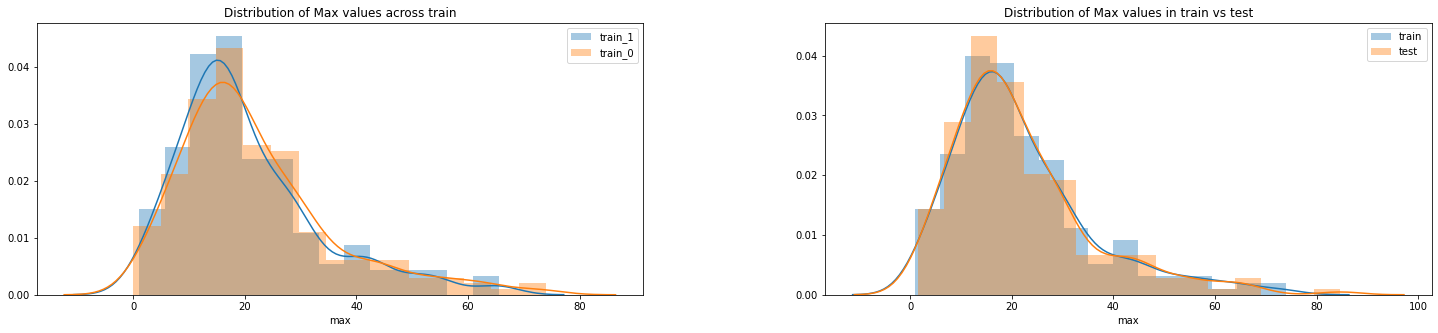

In [20]:
fig = plt.figure(figsize=(25,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3, )
ax = fig.add_subplot(1, 2, 1)
sns.distplot(train_summary_1.iloc[7], label="train_1" )
sns.distplot(train_summary_0.iloc[7], label="train_0" )
plt.title("Distribution of Max values across train")
plt.legend()
ax = fig.add_subplot(1, 2, 2)
sns.distplot(train_summary.iloc[7], label="train")
sns.distplot(test_summary.iloc[7], label="test" )
plt.title("Distribution of Max values in train vs test")
plt.legend();


In [21]:
features = train.columns.values[2:202]

# Univariate analysis

### Target class

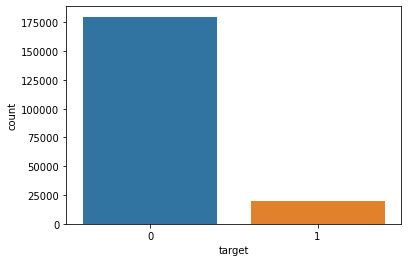

In [22]:
sns.countplot(train.target)

In [23]:
def density_plot(df1,df2,feat):
    plt.figure()
    fig,ax=plt.subplots(10,10,figsize=(20,20))
    for i,f in enumerate(feat):
        plt.subplot(10,10,i+1)
        sns.set_style('whitegrid')
        sns.kdeplot(df1[f])
        sns.kdeplot(df2[f])
        plt.legend(["class_0","class_1"])
        plt.xlabel(f,fontsize=9)
    plt.show()

In [24]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

<Figure size 432x288 with 0 Axes>

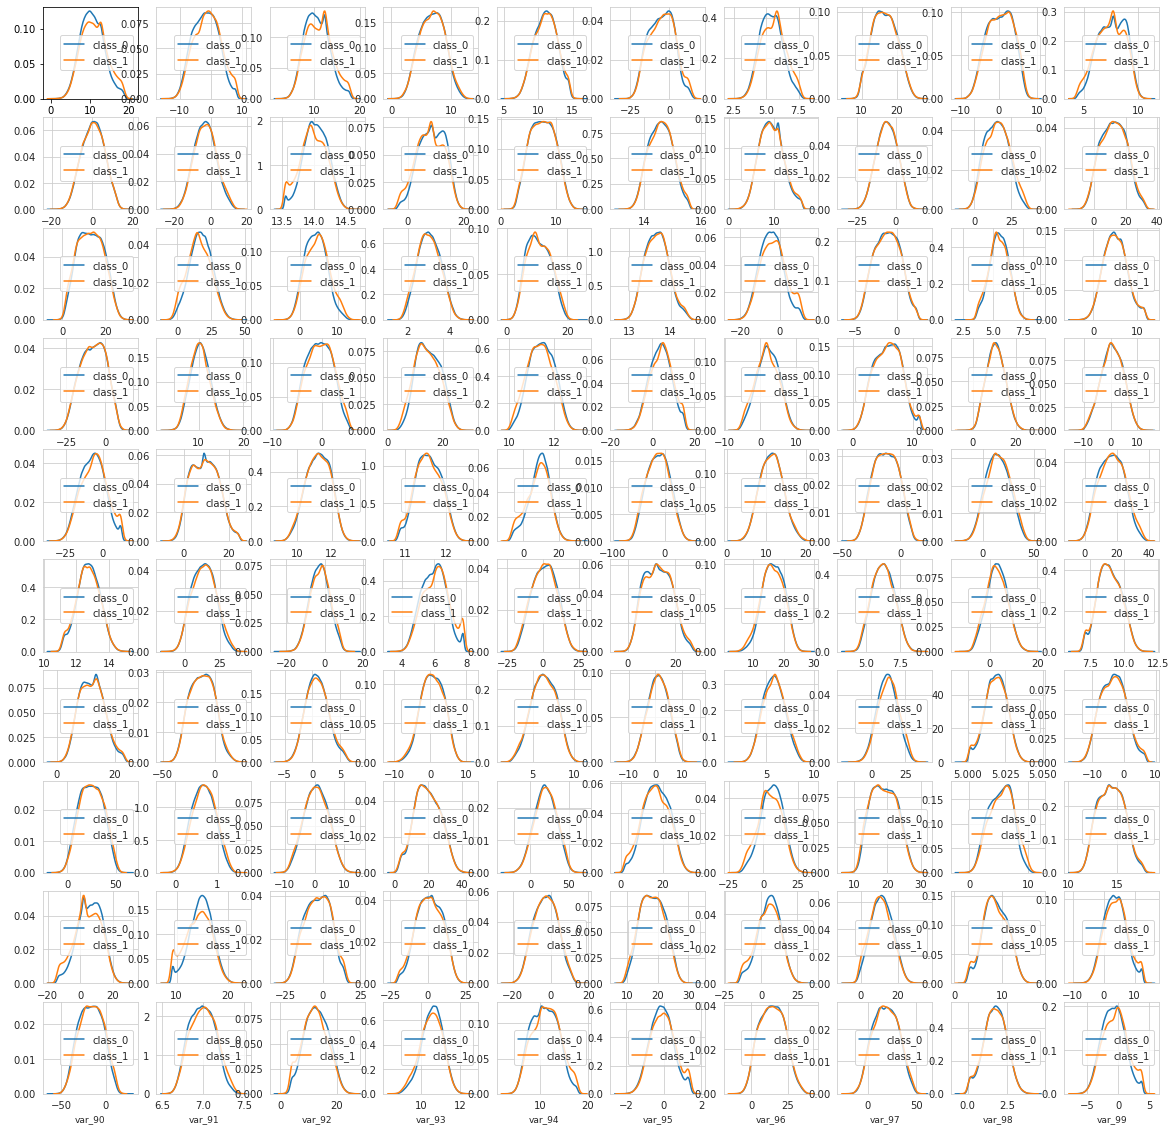

In [25]:
density_plot(train.loc[train.target==0],train.loc[train.target==1],train.columns[2:102])

<Figure size 432x288 with 0 Axes>

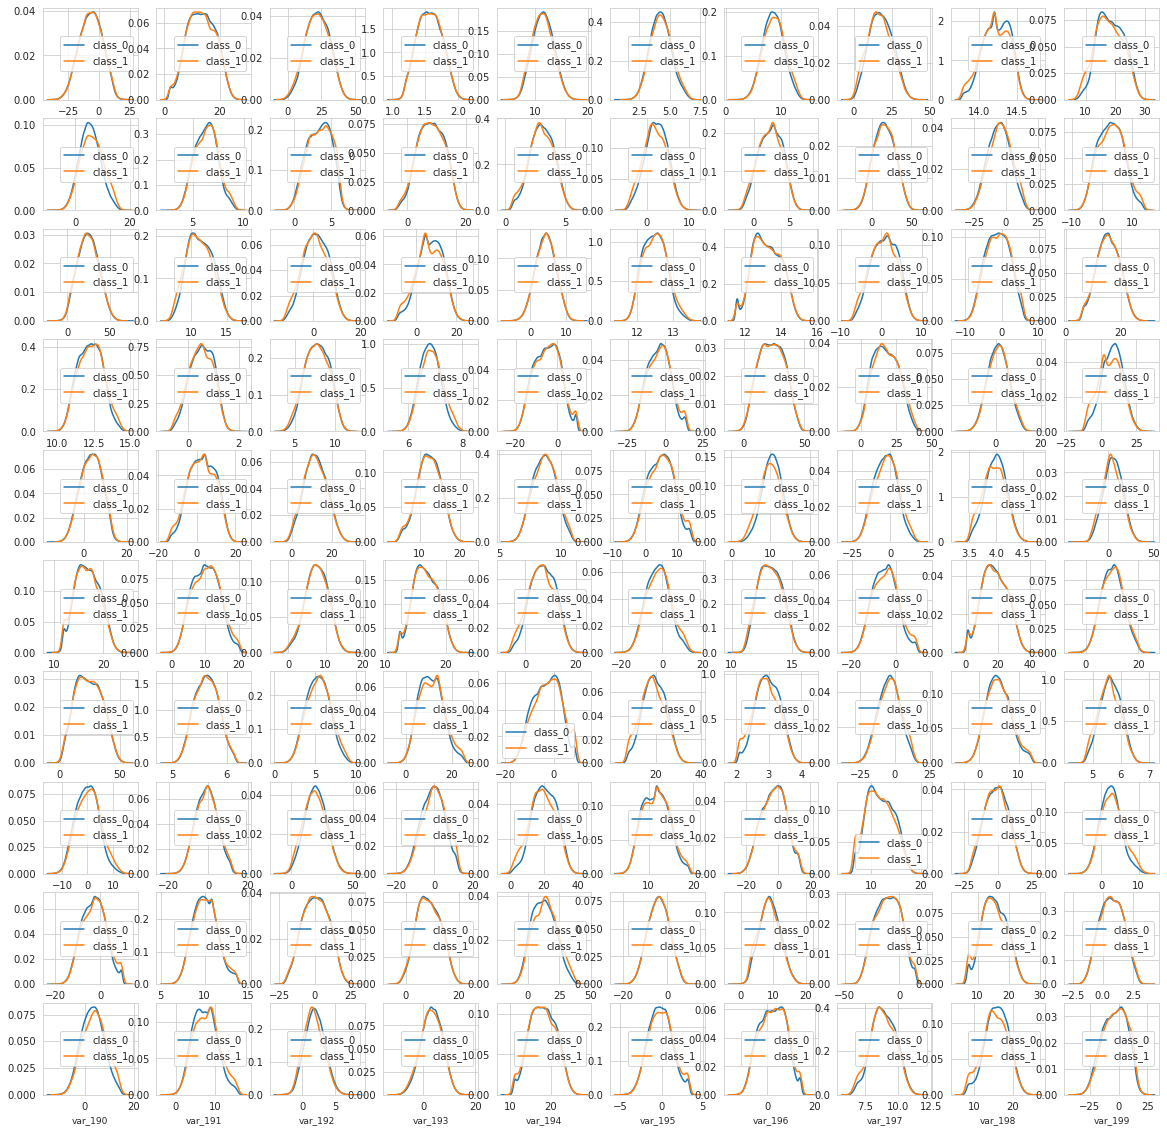

In [26]:
density_plot(train.loc[train.target==0],train.loc[train.target==1],train.columns[102:])

In [27]:
def density_plt(df,feat):
    plt.figure()
    fig,ax=plt.subplots(10,10,figsize=(25,25))
    for i,f in enumerate(feat):
        plt.subplot(10,10,i+1)
        sns.kdeplot(df[f])
        plt.xlabel(f,fontsize=9)
    plt.show()

<Figure size 432x288 with 0 Axes>

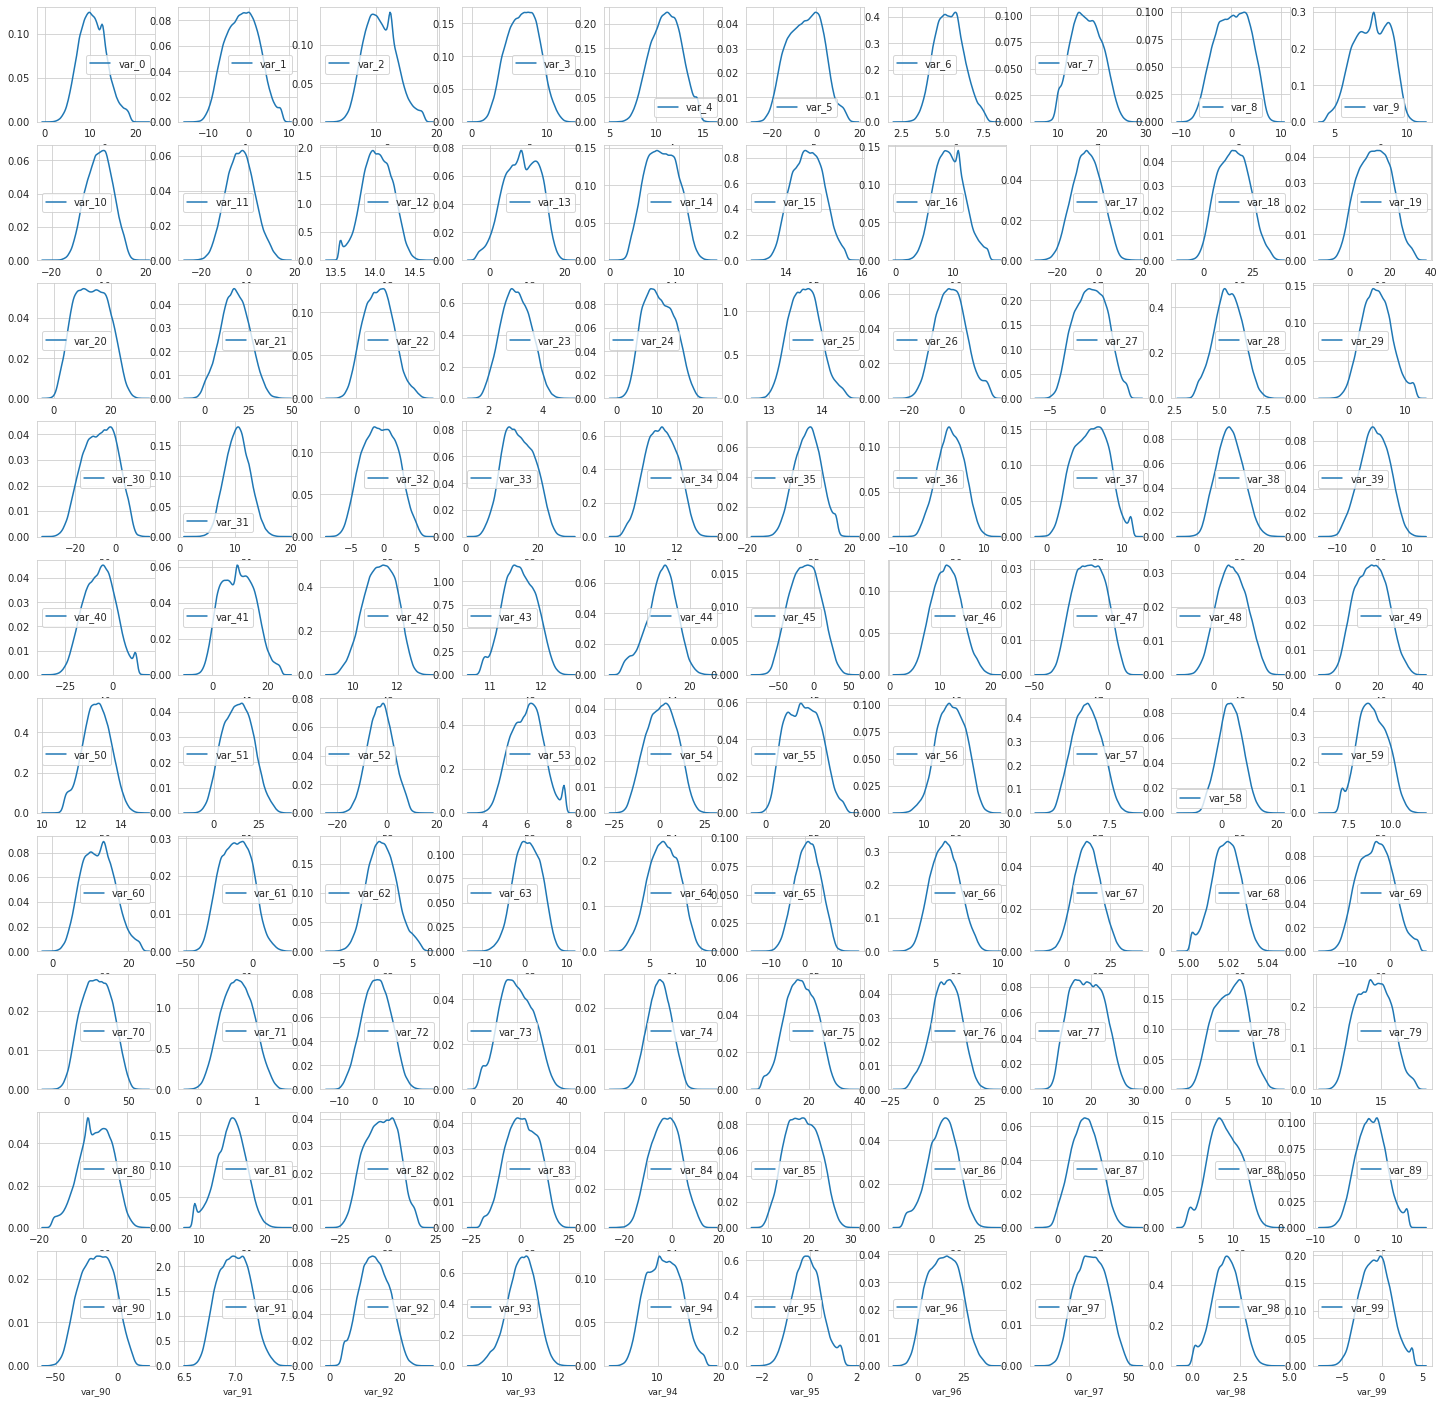

In [28]:
density_plt(test,test.columns[1:101])

<Figure size 432x288 with 0 Axes>

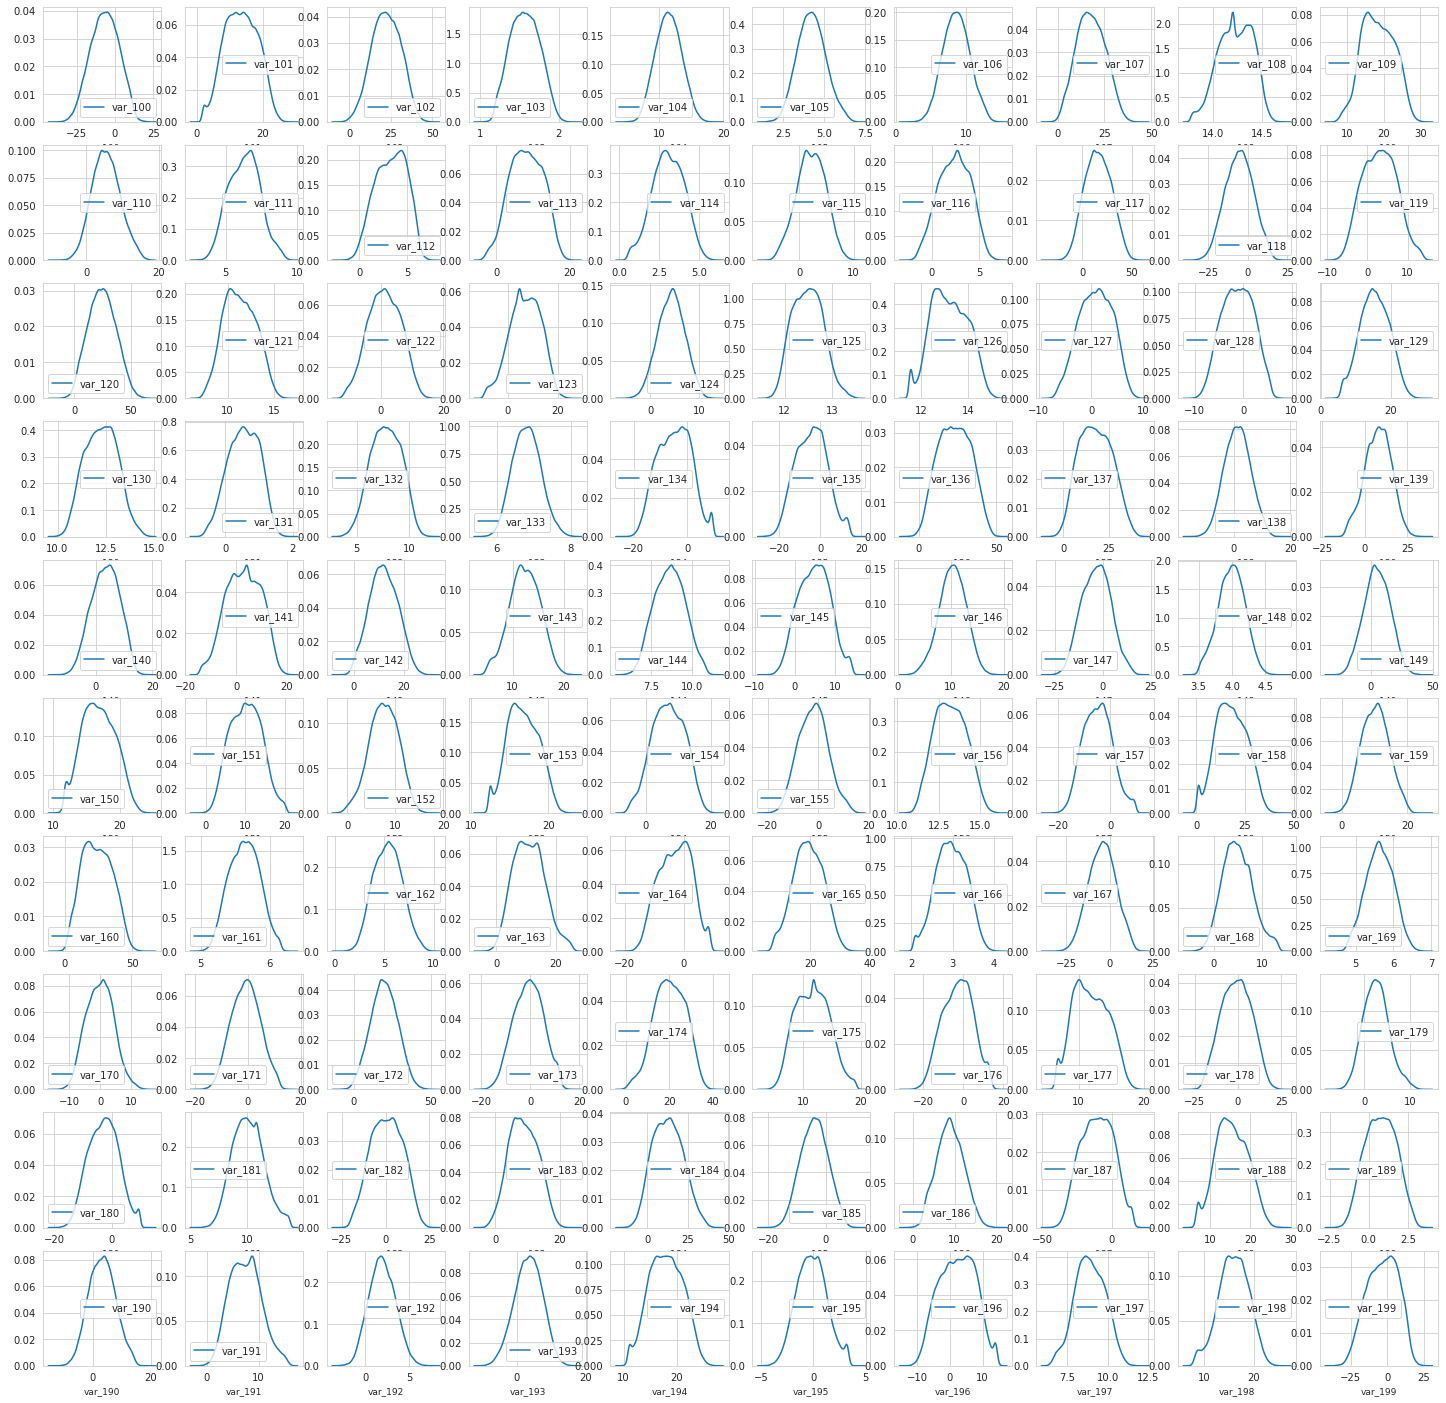

In [29]:
density_plt(test,test.columns[101:])

There are many varibles in which there is bump on left side 

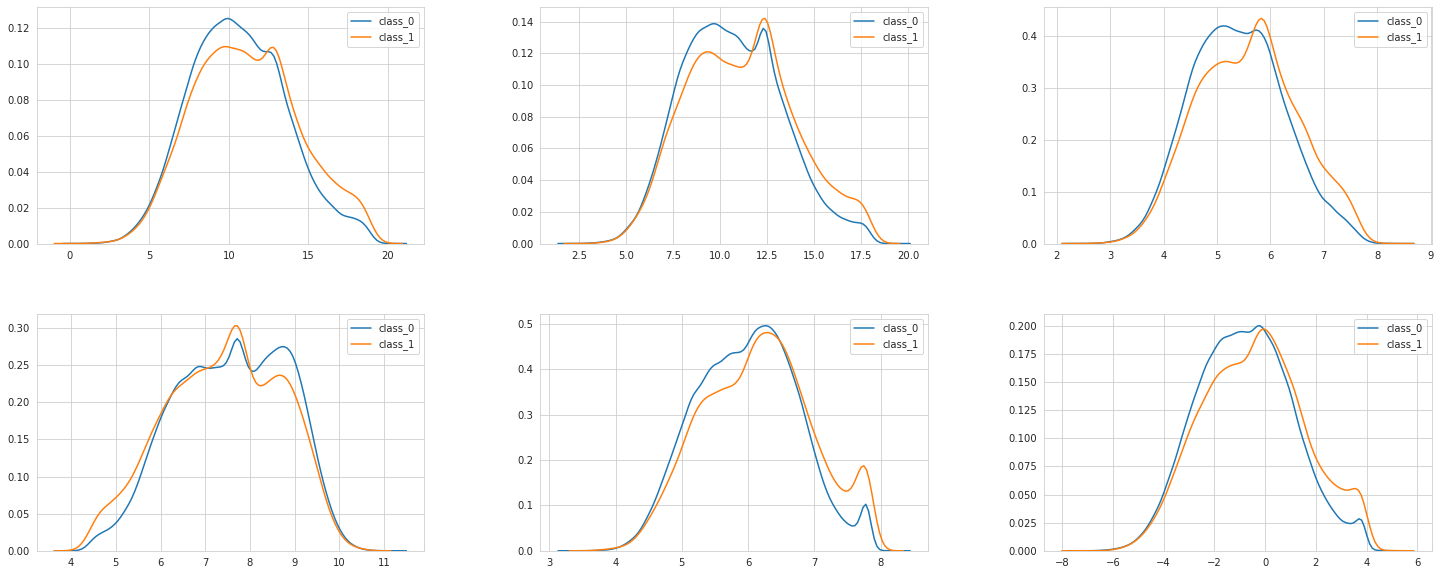

In [30]:
fig = plt.figure(figsize=(25,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3, )
ax = fig.add_subplot(2,3,1)
sns.kdeplot(train.loc[train.target==0]['var_0'])
sns.kdeplot(train.loc[train.target==1]['var_0'])
plt.legend(["class_0","class_1"])

ax = fig.add_subplot(2,3,2)
sns.kdeplot(train.loc[train.target==0]['var_2'])
sns.kdeplot(train.loc[train.target==1]['var_2'])
plt.legend(["class_0","class_1"])

ax = fig.add_subplot(2,3,3)
sns.kdeplot(train.loc[train.target==0]['var_6'])
sns.kdeplot(train.loc[train.target==1]['var_6'])
plt.legend(["class_0","class_1"])

ax = fig.add_subplot(2,3,4)
sns.kdeplot(train.loc[train.target==0]['var_9'])
sns.kdeplot(train.loc[train.target==1]['var_9'])
plt.legend(["class_0","class_1"])

ax = fig.add_subplot(2,3,5)
sns.kdeplot(train.loc[train.target==0]['var_53'])
sns.kdeplot(train.loc[train.target==1]['var_53'])
plt.legend(["class_0","class_1"])

ax = fig.add_subplot(2,3,6)
sns.kdeplot(train.loc[train.target==0]['var_99'])
sns.kdeplot(train.loc[train.target==1]['var_99'])
plt.legend(["class_0","class_1"])

## Finding Important Features

### Correlation analysis

In [31]:
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]


#### Most correlated features

In [32]:
correlations.tail(20)

level_0  level_1         0
39780    var_1   var_80  0.008855
39781   var_80    var_1  0.008855
39782  var_172   var_81  0.008936
39783   var_81  var_172  0.008936
39784  var_122  var_132  0.008956
39785  var_132  var_122  0.008956
39786   var_80    var_6  0.008958
39787    var_6   var_80  0.008958
39788  var_146  var_169  0.009071
39789  var_169  var_146  0.009071
39790  var_183  var_189  0.009359
39791  var_189  var_183  0.009359
39792  var_174   var_81  0.009490
39793   var_81  var_174  0.009490
39794   var_81  var_165  0.009714
39795  var_165   var_81  0.009714
39796   var_53  var_148  0.009788
39797  var_148   var_53  0.009788
39798   var_26  var_139  0.009844
39799  var_139   var_26  0.009844

#### least correlated

In [33]:
correlations.head(10)

level_0  level_1             0
0   var_75  var_191  2.703975e-08
1  var_191   var_75  2.703975e-08
2  var_173    var_6  5.942735e-08
3    var_6  var_173  5.942735e-08
4  var_126  var_109  1.313947e-07
5  var_109  var_126  1.313947e-07
6  var_144   var_27  1.772502e-07
7   var_27  var_144  1.772502e-07
8  var_177  var_100  3.116544e-07
9  var_100  var_177  3.116544e-07

In [34]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]


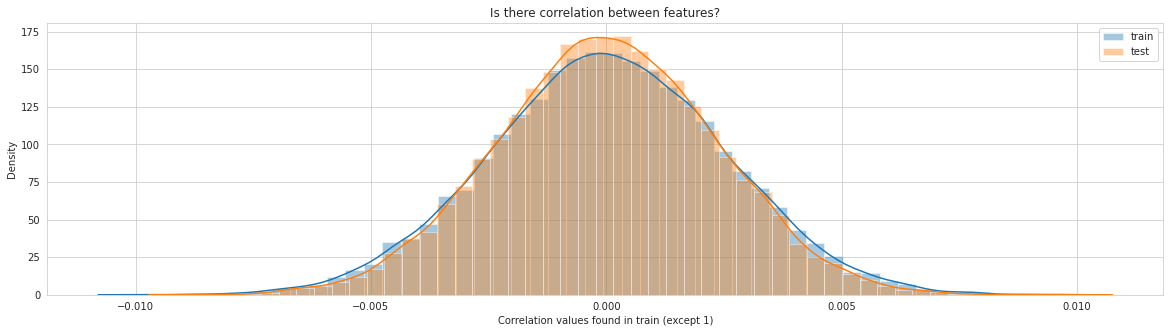

In [35]:
plt.figure(figsize=(20,5))
sns.distplot(train_correlations,  label="train")
sns.distplot(test_correlations,  label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Is there correlation between features?"); 
plt.legend();

In [36]:
train["Id"] = train.index.values
original_trainid = train.ID_code.values

train.drop("ID_code", axis=1, inplace=True)

In [37]:
train.head()

target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8  ...  var_191  var_192  var_193  var_194  var_195  var_196  var_197  \
0 -4.9200  ...   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   8.5635   
1  3.1468  ...   7.7214   2.5837  10.9516  15.4305   2.0339   8.1267   8.7889   
2 -4.9193  ...   9.7905   1.6704   1.6858  21.6042   3.1417  -6.5213   8.2675   
3 -5.8609  ...   4.7433   0.7178   1.4214  23.0347  -1.2706  -2.9275  10.2922   
4  6.2654  ...   9.5214  -0.1508   9.1942  13.2876  -1.5121   3.9267   9.5031   

   var_198  var_199  Id  
0  12.7803  -1.0914   0  
1  18.3560   1.9518   1  
2  14.7222   0.3965   2  
3  17.9697  -8.9996   3  
4  17.9974  -8.8104   4  

[5 rows x 202 columns]

### Top features through random Forest

In [38]:
parameters = {'min_samples_leaf': [20, 25]}
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid = GridSearchCV(forest, parameters, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))

In [39]:
grid.fit(train.drop(["target",], axis=1).values, train.target.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=15, n_estimators=15),
             n_jobs=-1, param_grid={'min_samples_leaf': [20, 25]},
             scoring=make_scorer(roc_auc_score), verbose=2)

In [40]:
grid.best_score_


0.5001298171532372

In [41]:
grid.best_params_

{'min_samples_leaf': 25}

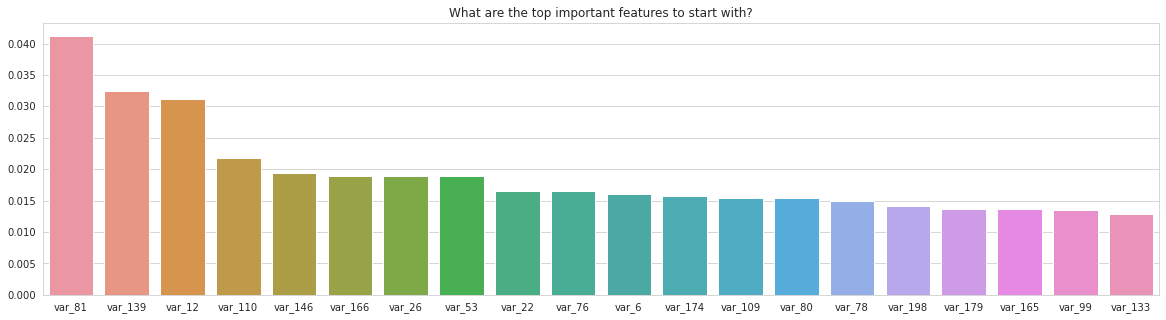

In [42]:
n_top = 20
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train.drop("target", axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("What are the top important features to start with?");

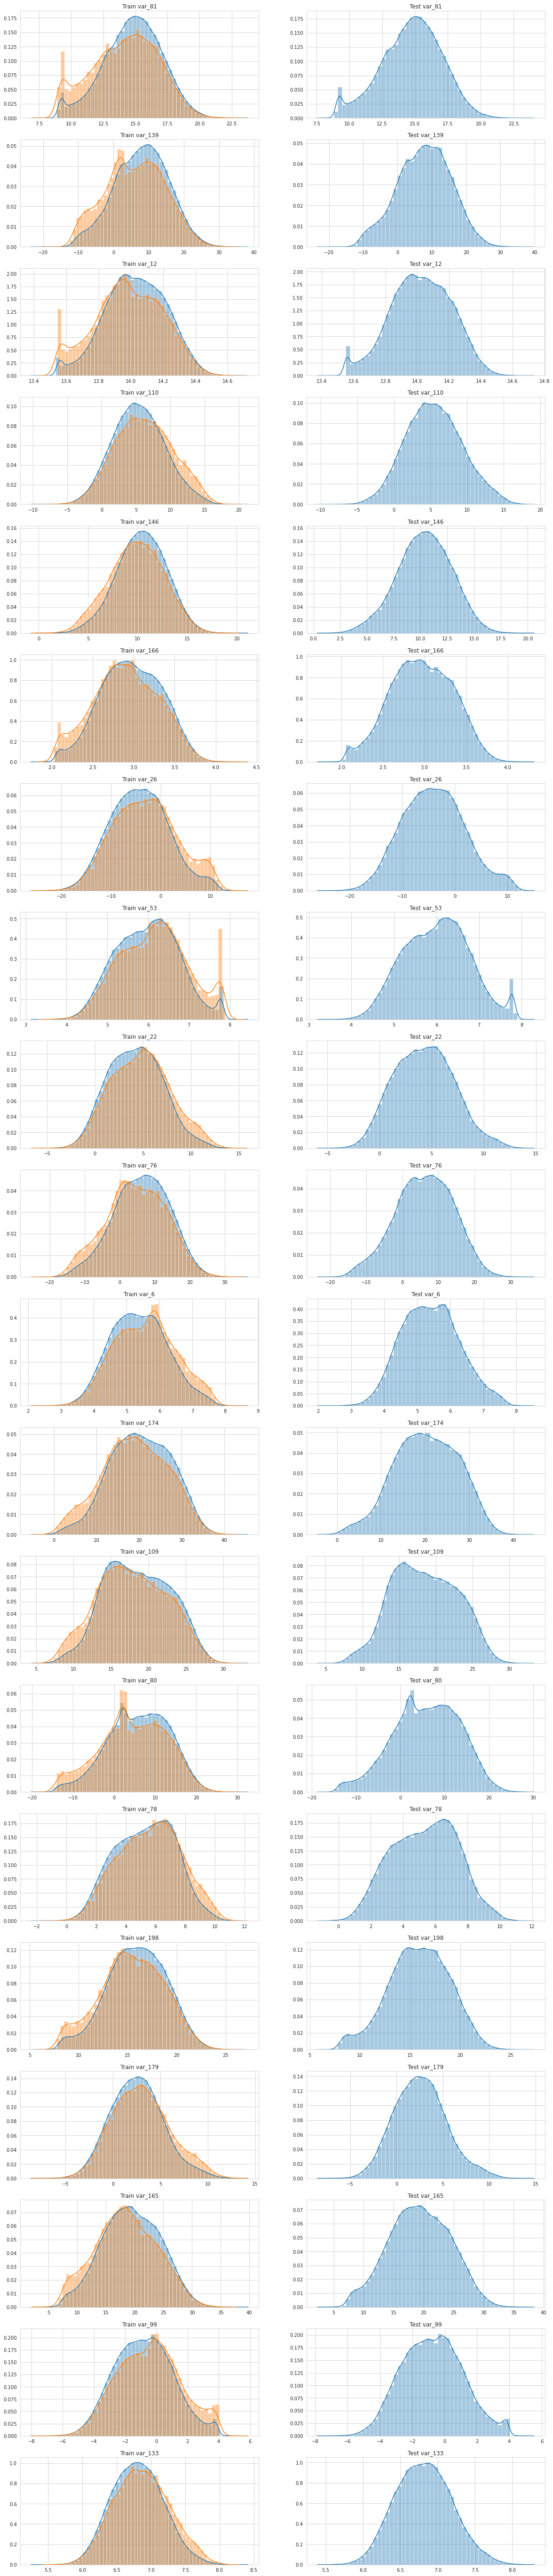

In [43]:
fig, ax = plt.subplots(n_top,2,figsize=(20,5*n_top))

for n in range(n_top):
    sns.distplot(train.loc[train.target==0, feature_names[idx][n]], ax=ax[n,0],  norm_hist=True)
    sns.distplot(train.loc[train.target==1, feature_names[idx][n]], ax=ax[n,0],  norm_hist=True)
    sns.distplot(test.loc[:, feature_names[idx][n]], ax=ax[n,1], norm_hist=True)
    ax[n,0].set_title("Train {}".format(feature_names[idx][n]))
    ax[n,1].set_title("Test {}".format(feature_names[idx][n]))
    ax[n,0].set_xlabel("")
    ax[n,1].set_xlabel("")

In [44]:
top = train.loc[:, feature_names[idx]]
top.describe()

var_81        var_139         var_12        var_110  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       14.719024       7.760193      14.023978       5.513238   
std         2.299567       7.686433       0.190059       3.823253   
min         7.586500     -21.274300      13.434600      -9.239800   
25%        13.214775       2.387575      13.894000       2.817475   
50%        14.844500       8.066250      14.025500       5.394300   
75%        16.340800      13.232525      14.164200       8.104325   
max        23.132400      36.097100      14.654500      19.519300   

             var_146        var_166         var_26         var_53  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.341178       2.963335      -4.055133       6.008569   
std         2.518883       0.369684       5.922210       0.764753   
min         0.427400       1.851200     -24.243100       3.344900   
25%         8.646900       2.699000      -8.321725       5.435600   
50%        10.395600       2.960200      -4.196900       6.027800   
75%        12.113225       3.241500      -0.090200       6.542900   
max        20.437300       4.220400      15.675100       8.231500   

              var_22         var_76          var_6        var_174  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        4.305430       6.050871       5.408949      20.210677   
std         2.847958       7.938351       0.866607       7.136427   
min        -5.322500     -21.633300       2.347300      -2.995300   
25%         2.182400       0.596300       4.767700      15.064600   
50%         4.275150       6.297800       5.385100      20.206100   
75%         6.293200      11.818800       6.003000      25.641225   
max        14.594500      34.435200       8.447700      43.546800   

             var_109         var_80         var_78        var_198  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       18.458001       5.795044       5.349479      15.870720   
std         4.355031       7.436737       1.993792       3.010945   
min         5.769700     -18.042200      -1.818300       6.299300   
25%        15.107175       0.694475       3.817275      13.829700   
50%        18.281350       6.061750       5.440050      15.934050   
75%        21.852900      11.449125       6.867200      18.064725   
max        32.059100      30.476900      11.350700      26.079100   

             var_179        var_165         var_99        var_133  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.591444      19.315753      -0.746296       6.813270  
std         2.798956       5.024182       1.862550       0.375603  
min        -7.856100       3.816700      -7.280600       5.359300  
25%         0.625575      15.744550      -2.106200       6.543500  
50%         2.512300      19.270800      -0.771300       6.806700  
75%         4.391125      23.024025       0.528500       7.070800  
max        13.448700      38.332200       5.076400       8.309100

In [45]:
top = top.join(train.target)
sns.pairplot(top, hue="target")

### Weight of Evidence (WOE)
The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan.

WOE Calculation

Steps of Calculating WOE
For a continuous variable, split data into 10 parts (or lesser depending on the distribution).
Calculate the number of events and non-events in each group (bin)
Calculate the % of events and % of non-events in each group.
Calculate WOE by taking natural log of division of % of non-events and % of events


### Information Value (IV)
Information value is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance. The IV is calculated using the following formula :
> **IV = ∑ (% of non-events - % of events) * WOE**


Information Value	Variable Predictiveness <br>
* Less than 0.02	Not useful for prediction<br>
* 0.02 to 0.1	Weak predictive Power<br>
* 0.1 to 0.3	Medium predictive Power<br>
* 0.3 to 0.5	Strong predictive Power<br>
* > 0.5	Suspicious Predictive Power<br>

#### ref https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html


In [46]:
def woe(X, y):
    tmp = pd.DataFrame()
    tmp["variable"] = X
    tmp["target"] = y
    var_counts = tmp.groupby("variable")["target"].count()
    var_events = tmp.groupby("variable")["target"].sum()
    var_nonevents = var_counts - var_events
    tmp["var_counts"] = tmp.variable.map(var_counts).astype("float64")
    tmp["var_events"] = tmp.variable.map(var_events).astype("float64")
    tmp["var_nonevents"] = tmp.variable.map(var_nonevents).astype("float64")
    events = sum(tmp["target"] == 1)
    nonevents = sum(tmp["target"] == 0)
    tmp["woe"] = np.log(((tmp["var_nonevents"])/nonevents)/((tmp["var_events"])/events))
    tmp["woe"] = tmp["woe"].replace(np.inf, 0).replace(-np.inf, 0)
    tmp["iv"] = (tmp["var_nonevents"]/nonevents - tmp["var_events"]/events) * tmp["woe"]
    iv = tmp.groupby("variable")["iv"].last().sum()
    return tmp["woe"], tmp["iv"], iv

In [47]:
iv_values = []
feats = ["var_{}".format(i) for i in range(200)]
y = train["target"]
for f in feats:
    X = pd.qcut(train[f], 10, duplicates='drop')
    _, _, iv = woe(X, y)
    iv_values.append(iv)
    
iv_inds = np.argsort(iv_values)[::-1][:50]
iv_values = np.array(iv_values)[iv_inds]
feats = np.array(feats)[iv_inds]

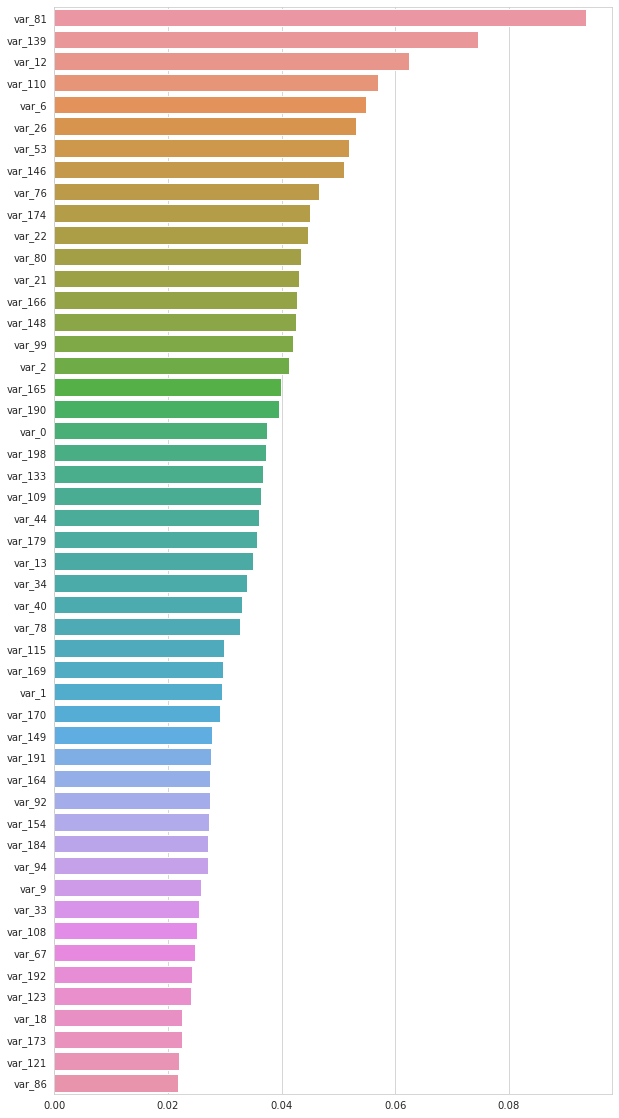

In [48]:
plt.figure(figsize=(10, 20))
sns.barplot(y=feats, x=iv_values, orient='h')
plt.show()

In [49]:
imp = {}
imp["feature_name"] = feats
imp["iv_value"] = iv_values
imp_features = pd.DataFrame(data=imp)

In [50]:
imp_features.sort_values(by = ["iv_value"],ascending=False)

feature_name  iv_value
0        var_81  0.093580
1       var_139  0.074582
2        var_12  0.062416
3       var_110  0.057046
4         var_6  0.054804
5        var_26  0.053017
6        var_53  0.051905
7       var_146  0.051071
8        var_76  0.046606
9       var_174  0.044973
10       var_22  0.044573
11       var_80  0.043412
12       var_21  0.043100
13      var_166  0.042635
14      var_148  0.042483
15       var_99  0.042041
16        var_2  0.041336
17      var_165  0.039975
18      var_190  0.039500
19        var_0  0.037399
20      var_198  0.037223
21      var_133  0.036755
22      var_109  0.036365
23       var_44  0.036004
24      var_179  0.035667
25       var_13  0.035035
26       var_34  0.033978
27       var_40  0.032953
28       var_78  0.032734
29      var_115  0.029940
30      var_169  0.029751
31        var_1  0.029528
32      var_170  0.029132
33      var_149  0.027703
34      var_191  0.027549
35      var_164  0.027451
36       var_92  0.027327
37      var_154  0.027207
38      var_184  0.027010
39       var_94  0.026962
40        var_9  0.025888
41       var_33  0.025514
42      var_108  0.025050
43       var_67  0.024684
44      var_192  0.024166
45      var_123  0.024052
46       var_18  0.022487
47      var_173  0.022392
48      var_121  0.021920
49       var_86  0.021769

# Feature Engineering

In [51]:
top_features = imp_features["feature_name"].iloc[0:20].values

In [52]:
top_features = top_features.tolist()
top_features

['var_81',
 'var_139',
 'var_12',
 'var_110',
 'var_6',
 'var_26',
 'var_53',
 'var_146',
 'var_76',
 'var_174',
 'var_22',
 'var_80',
 'var_21',
 'var_166',
 'var_148',
 'var_99',
 'var_2',
 'var_165',
 'var_190',
 'var_0']

In [53]:
# adding feature from top to top_features
for i in top.columns:
    top_features.append(i)

In [54]:
#removing duplicates
top_features = list(set(top_features))
top_features

['var_109',
 'var_148',
 'var_198',
 'var_81',
 'var_190',
 'var_78',
 'var_133',
 'var_0',
 'target',
 'var_166',
 'var_21',
 'var_99',
 'var_110',
 'var_76',
 'var_6',
 'var_2',
 'var_12',
 'var_22',
 'var_179',
 'var_174',
 'var_165',
 'var_26',
 'var_146',
 'var_53',
 'var_80',
 'var_139']

In [55]:
new_top = train[top_features]
new_top.head()

var_109  var_148  var_198   var_81  var_190  var_78  var_133    var_0  \
0  24.3627   4.0288  12.7803  13.8372   4.4354  6.5199   6.5674   8.9255   
1  13.0858   4.2578  18.3560  18.1782   7.6421  5.5075   7.0513  11.5006   
2  20.3882   4.0714  14.7222  15.7811   2.9057  6.3191   6.6231   8.6093   
3  14.4135   3.7613  17.9697  10.5404   4.4666  4.0806   7.1954  11.0604   
4  28.2749   3.7574  17.9974  13.3317  -1.4905  7.1734   6.6173   9.8369   

   target  var_166  ...   var_12   var_22  var_179  var_174  var_165   var_26  \
0       0   2.7004  ...  14.0137   2.5791   1.7202  18.5618  12.6644  -5.1488   
1       0   3.2003  ...  14.0239   8.5524  11.0752  30.2645  15.1345 -11.7684   
2       0   3.2790  ...  14.1929   1.2145   2.4013  25.6820  20.5092  -7.9940   
3       0   2.5881  ...  13.8463   6.8202   5.6961  14.7483  17.2502   0.8135   
4       0   3.2304  ...  13.8481  10.1102   5.1743  18.4685  21.2607   3.1736   

   var_146  var_53   var_80  var_139  
0  11.5659  5.1736  13.6468  15.6599  
1   8.9231  6.6885   2.5462  16.1622  
2  11.4934  6.4059   7.4729   8.6674  
3  10.4994  5.2091   0.7839   8.9821  
4  11.5670  5.7555   2.9598  13.9547  

[5 rows x 26 columns]

In [56]:
new_top.shape

(200000, 26)

In [57]:
encoder = LabelEncoder()
for your_feature in top_features:
    if(your_feature == "target"):
        pass
    elif(your_feature == "ID"):
        pass
    else:
        train[your_feature + "_qbinned"] = pd.qcut(
            train.loc[:, your_feature].values,
            q=10,
            duplicates='drop',
            labels=False
        )
        train[your_feature + "_qbinned"] = encoder.fit_transform(
            train[your_feature + "_qbinned"].values.reshape(-1, 1)
        )


        train[your_feature + "_rounded"] = np.round(train.loc[:, your_feature].values)
        train[your_feature + "_rounded_10"] = np.round(10*train.loc[:, your_feature].values)
        train[your_feature + "_rounded_100"] = np.round(100*train.loc[:, your_feature].values)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [58]:
encoder = LabelEncoder()
for your_feature in top_features:
    if(your_feature == "target"):
        pass
    else:
        test[your_feature + "_qbinned"] = pd.qcut(
            test.loc[:, your_feature].values,
            q=10,
            duplicates='drop',
            labels=False
        )
        test[your_feature + "_qbinned"] = encoder.fit_transform(
            test[your_feature + "_qbinned"].values.reshape(-1, 1)
        )


        test[your_feature + "_rounded"] = np.round(test.loc[:, your_feature].values)
        test[your_feature + "_rounded_10"] = np.round(10*test.loc[:, your_feature].values)
        test[your_feature + "_rounded_100"] = np.round(100*test.loc[:, your_feature].values)

In [59]:
train.head()

target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8  ...  var_53_rounded_10  var_53_rounded_100  var_80_qbinned  \
0 -4.9200  ...               52.0               517.0               8   
1  3.1468  ...               67.0               669.0               3   
2 -4.9193  ...               64.0               641.0               5   
3 -5.8609  ...               52.0               521.0               2   
4  6.2654  ...               58.0               576.0               3   

   var_80_rounded  var_80_rounded_10  var_80_rounded_100  var_139_qbinned  \
0            14.0              136.0              1365.0                8   
1             3.0               25.0               255.0                8   
2             7.0               75.0               747.0                5   
3             1.0                8.0                78.0                5   
4             3.0               30.0               296.0                7   

   var_139_rounded  var_139_rounded_10  var_139_rounded_100  
0             16.0               157.0               1566.0  
1             16.0               162.0               1616.0  
2              9.0                87.0                867.0  
3              9.0                90.0                898.0  
4             14.0               140.0               1395.0  

[5 rows x 302 columns]

In [60]:
# Deriving the New Features for the training dataset
mean_r=train.iloc[:,2:].mean(axis=1).values
min_r=train.iloc[:,2:].min(axis=1).values
max_r=train.iloc[:,2:].max(axis=1).values
std_r=train.iloc[:,2:].std(axis=1).values
skew_r=train.iloc[:,2:].skew(axis=1).values
kurto_r=train.iloc[:,2:].kurtosis(axis=1).values
median_r=train.iloc[:,2:].median(axis=1).values

In [61]:
## Adding the new features to the training dataset
train["mean_r"]=mean_r
train["min_r"]=min_r
train["max_r"]=max_r
train["std_r"]=std_r
train["skew_r"]=skew_r
train["kurto_r"]=kurto_r
train["median_r"]=median_r

In [62]:
# Deriving the New Features for the testing dataset
mean_r=test.iloc[:,2:].mean(axis=1).values
min_r=test.iloc[:,2:].min(axis=1).values
max_r=test.iloc[:,2:].max(axis=1).values
std_r=test.iloc[:,2:].std(axis=1).values
skew_r=test.iloc[:,2:].skew(axis=1).values
kurto_r=test.iloc[:,2:].kurtosis(axis=1).values
median_r=test.iloc[:,2:].median(axis=1).values

## Adding the new features to the testing dataset
test["mean_r"]=mean_r
test["min_r"]=min_r
test["max_r"]=max_r
test["std_r"]=std_r
test["skew_r"]=skew_r
test["kurto_r"]=kurto_r
test["median_r"]=median_r

In [63]:
test.shape

(200000, 308)

In [64]:
train.shape

(200000, 309)

In [65]:
for i in train.columns.values:
    if i not in test.columns.values:
        print( i)

target
Id


# New feature importances

In [66]:
iv_values = []
feats = train.columns.values
y = train["target"]
for f in feats:
    X = pd.qcut(train[f], 10, duplicates='drop')
    _, _, iv = woe(X, y)
    iv_values.append(iv)
    
iv_inds = np.argsort(iv_values)[::-1][:50]
iv_values = np.array(iv_values)[iv_inds]
feats = np.array(feats)[iv_inds]

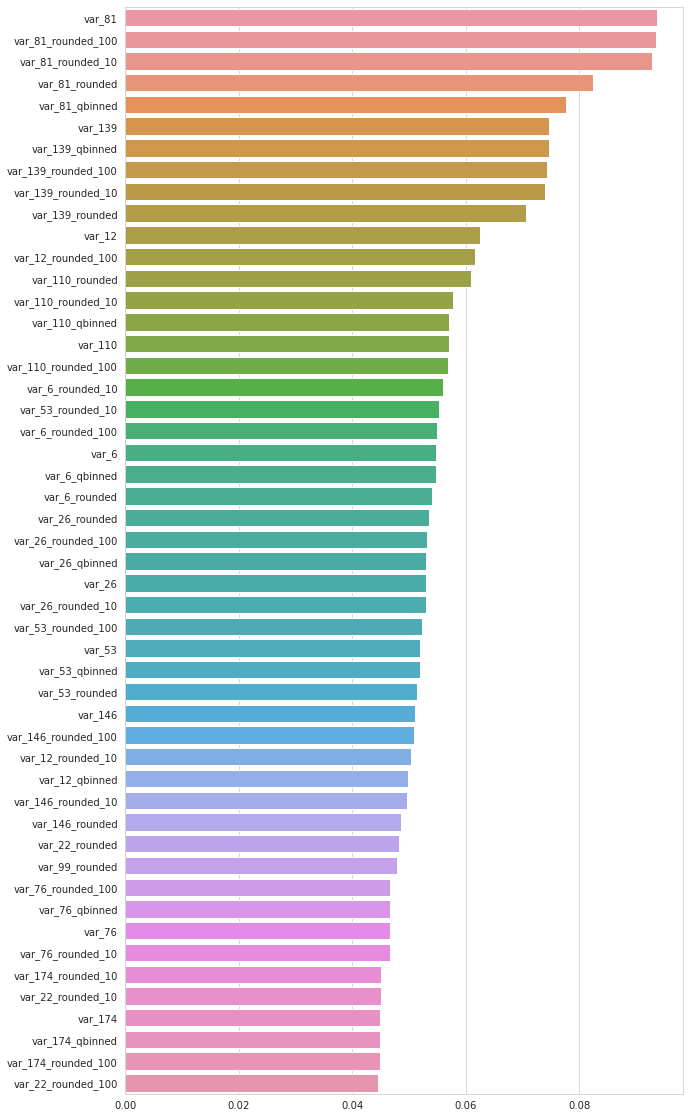

In [67]:
plt.figure(figsize=(10, 20))
sns.barplot(y=feats, x=iv_values, orient='h')
plt.show()

In [68]:
# train.to_csv("new_train.csv")
# test.to_csv("new_test.csv")